# Image Classification with CNN using Keras

# Import Libraries

In [1]:
import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')
    
print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.0.1
Is using GPU? False


# Preprocess Data

In [2]:
def get_three_classes(x, y):
    indices_0, _ = np.where(y == 0.)
    indices_1, _ = np.where(y == 1.)
    indices_2, _ = np.where(y == 2.)

    indices = np.concatenate([indices_0, indices_1, indices_2], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, y_train = get_three_classes(x_train, y_train)
x_test, y_test = get_three_classes(x_test, y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


# Visualize Examples

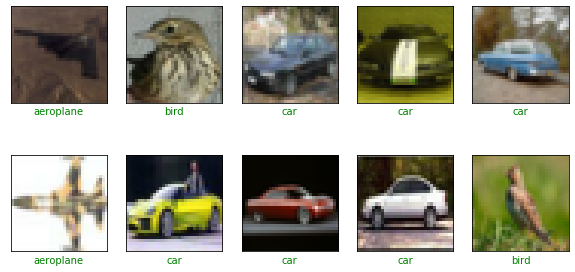

In [5]:
class_names = ['aeroplane', 'car', 'bird']

def show_random_examples(x,y,p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2,5,1+i)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()
    
show_random_examples(x_train, y_train, y_train)     #still no prediction part

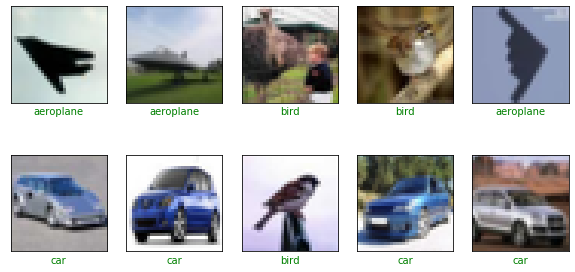

In [6]:
show_random_examples(x_test, y_test, y_test) 

# Create Model

In [9]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
    def add_conv_block(model, num_filters):
        model.add(Conv2D(num_filters, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.5))
        return model
    
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(32, 32, 3)))
    
    model = add_conv_block(model,32)
    model = add_conv_block(model,64)
    model = add_conv_block(model,128)
    
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))   #nodes=3
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam', metrics = ['accuracy']
    )
    return model

model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)       

# Train the Model

In [13]:
h = model.fit(
    x_train/255., #normalize
    y_train,
    validation_data=(x_test/255.,y_test),
    epochs=10, 
    batch_size=128,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),   #Early Stop
        tf.keras.callbacks.ModelCheckpoint(
            'models/model_{val_accuracy:.3f}.h5',
            save_best_only = True,
            save_weights_only = False,
            monitor = 'val_accuracy'
        )
    ]
)

Train on 15000 samples, validate on 3000 samples
Epoch 1/10
15000/15000 [==============================] - 129s 9ms/sample - loss: 0.4912 - accuracy: 0.8036 - val_loss: 2.8575 - val_accuracy: 0.3690
Epoch 2/10
15000/15000 [==============================] - 129s 9ms/sample - loss: 0.4413 - accuracy: 0.8255 - val_loss: 1.0256 - val_accuracy: 0.6410
Epoch 3/10
15000/15000 [==============================] - 128s 9ms/sample - loss: 0.4064 - accuracy: 0.8397 - val_loss: 0.8141 - val_accuracy: 0.7320
Epoch 4/10
15000/15000 [==============================] - 132s 9ms/sample - loss: 0.3799 - accuracy: 0.8517 - val_loss: 0.4155 - val_accuracy: 0.8307
Epoch 5/10
15000/15000 [==============================] - 134s 9ms/sample - loss: 0.3507 - accuracy: 0.8636 - val_loss: 0.3029 - val_accuracy: 0.8890
Epoch 6/10
15000/15000 [==============================] - 129s 9ms/sample - loss: 0.3211 - accuracy: 0.8743 - val_loss: 1.0749 - val_accuracy: 0.7233
Epoch 7/10
15000/15000 [===========================

# Final Predictions

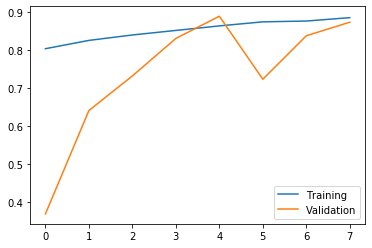

In [16]:
accs = h.history['accuracy']
val_accs = h.history['val_accuracy']

plt.plot(range(len(accs)), accs, label = 'Training')
plt.plot(range(len(accs)), val_accs, label = 'Validation')
plt.legend()
plt.show()

In [17]:
model = tf.keras.models.load_model('models/model_0.889.h5')

In [18]:
preds = model.predict(x_test/255.)

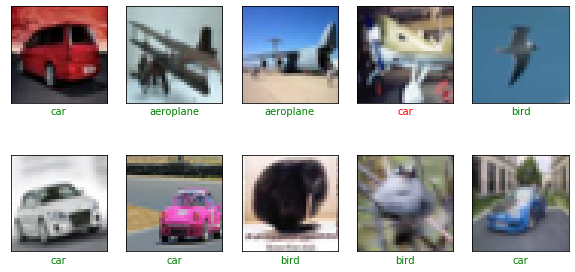

In [19]:
show_random_examples(x_test, y_test, preds)